# Aktív tanulás

A félkarú rabló mintájára legyen adott $K$-karú játékgép, ahol, ha szerencsénk van, egy kart meghúzva valamekkora jutalomban (*reward*) részesülhetünk. Az egyes karok által adott jutalmak valószínűségi változók, amelyek ismeretlen, egymástól független eloszlásokat követnek. A célunk, hogy a karok egymás után történő húzogatásával
- Felfedezzük a problémateret, azaz megbecsüljük az egyes karok "jóságát" (*exploration*),
- Ezt a tudást kihasználva maximalizáljuk az összes jutalmunkat (*exploitation*).

Érezzük, hogy a két cél egymásnak ellentmond: a felfedezéshez szuboptimális karokat is meg kell húznunk, ezzel azonban az összes jutalmunkat csökkentjük. A karok valószínűségi természete miatt az is előfordulhat, hogy egy-egy "jó" kar éppen rossz jutalmat ad, így érdemes lehet a pillanatnyilag rossznak gondolt karokat is többször tesztelni. Ez az *exploration vs. exploitation* dilemma.

Bár az általunk vizsgált stratégiák többféle eloszlás esetében is működnek, mi a már jól ismert Bernoulli-eloszlást fogjuk használni. Azaz minden karhoz tartozik egy ismeretlen $\theta_k$ paraméter, amely annak valószínűségét jelöli, hogy a kartól kapunk $1$ egység jutalmat. Egy húzás így egy Bernoulli-kísérletnek felel meg:

\begin{align}
p\left(y \mid \theta_k \right) = \mathcal{B}ern \left(y \mid \theta_k \right) = \theta_k^{y} (1-\theta_k)^{1-y},
\end{align}

ahol $y \in \left\lbrace 0,1 \right\rbrace$ a $k$. kar meghúzása után kapott jutalom. A továbbiakban jelölje $\bar y_k$ a $k.$ kar által adott jutalmak átlagát, $n_k$ azt, hogy hányszor húztuk meg a $k$. kart, $n$ pedig az összes húzások számát egészen mostanáig.

## Stratégiák

A következő stratégiákat fogjuk implementálni (párat láttuk előadáson):

- $\varepsilon$-greedy: adott $\varepsilon$ valószínűséggel felfedezünk, azaz véletlenszerűen válaszott kart húzunk meg; különben azt, amelyik eddig átlagosan a legnagyobb jutalmat adta (azaz $\bar y_k$ maximális).
- UCB1: először minden kart meghúzunk egyszer, majd mindig azt húzzuk, amelyik a $\bar y_k + \sqrt{\frac{2 \ln n}{n_k}}$ mennyiséget maximalizálja.
- UCB-$\alpha$: hasonlóan az előbbihez, de $\bar y_k + \sqrt{\frac{\alpha \ln n}{n_k}}$-t használunk.
- Thompson-mintavétel: minden karra felteszünk egy $\beta$ prior eloszlást, majd mintát veszünk és a maximálisat választjuk; a jutalom ismeretében a $\beta$-eloszlás frissítése a már ismert módon történik (konjugált eloszlások).
- Bayesi UCB: hasonlóképpen fenntartunk egy $\beta$-eloszlást, de a választásnál nem mintát veszünk, hanem $1- \frac{1}{1+n}$ percentilist veszünk alapul (pl. a `beta.ppf()` függvénnyel).

## Feladatok

**1. feladat.** Valósítsa meg az ágenseket a lenti prototípus alapján! Az ágenseknek a `get_arm()` és az `update()` függvényeket kötelező implementálniuk.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import beta

In [ ]:
# Prototípus ágens (példa)
class Agent:
  def __init__(self,K):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    self.arm = np.random.choice(self.K)
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]

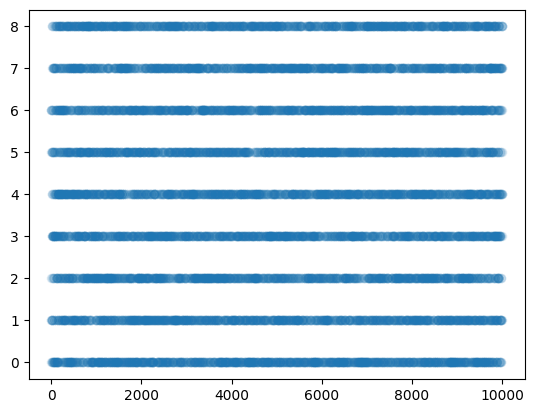

In [ ]:
# 2. feladat megoldása
agent = Agent(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

A kiértékeléshez a következő esetet fogjuk használni:

In [ ]:
rewards = [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]

Itt pedig a szimulációhoz használható kód látható:

In [ ]:
# Szimuláció T db húzással
def simulate(rewards,agent,T=10000):
  for t in range(T):
    arm    = agent.get_arm()
    reward = (np.random.rand()<rewards[arm])*1
    agent.update(reward)

In [ ]:
# 1. feladat megoldása
class Egreedy:
  def __init__(self,K,e=0.01):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

    self.x = np.zeros(K) # nyilvantartjuk
    self.n = np.ones(K)
    self.e = e

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    if np.random.rand() < self.e:
      self.arm = np.random.choice(self.K)
    else:
      self.arm = np.argmax(self.x / self.n)
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.x[self.arm] += reward
    self.n[self.arm] += 1


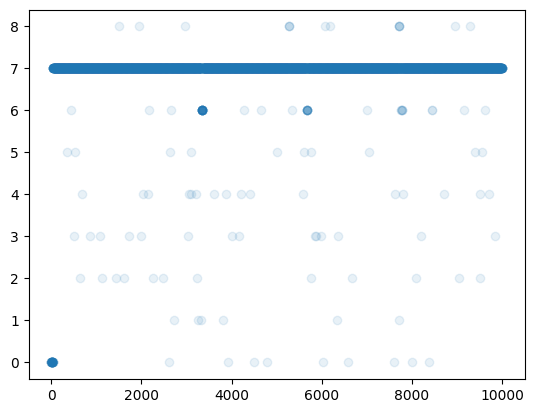

In [ ]:
# 2. feladat megoldása
agent = Egreedy(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

In [ ]:
# 1. feladat megoldása UCB
class UCB1:
  def __init__(self,K):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma

    self.x = np.zeros(K) # nyilvantartjuk
    self.n = np.zeros(K)

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    m = np.sum(self.n)
    if m < self.K:
      self.arm = int(m)
    else:
      self.arm = np.argmax(self.x / self.n + np.sqrt(2*np.log(m)/self.n))
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.x[self.arm] += reward
    self.n[self.arm] += 1


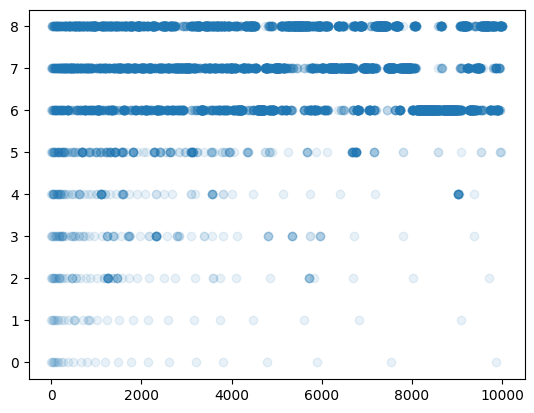

In [ ]:
# 2. feladat megoldása
agent = UCB1(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

In [ ]:
# 1. feladat megoldása UCB-𝛼
class UCBA:
  def __init__(self,K,alpha):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma
    self.alpha = alpha
    self.x = np.zeros(K) # nyilvantartjuk
    self.n = np.zeros(K)

  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    m = np.sum(self.n)
    if m < self.K:
      self.arm = int(m)
    else:
      self.arm = np.argmax(self.x / self.n + np.sqrt(self.alpha*np.log(m)/self.n))
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.x[self.arm] += reward
    self.n[self.arm] += 1

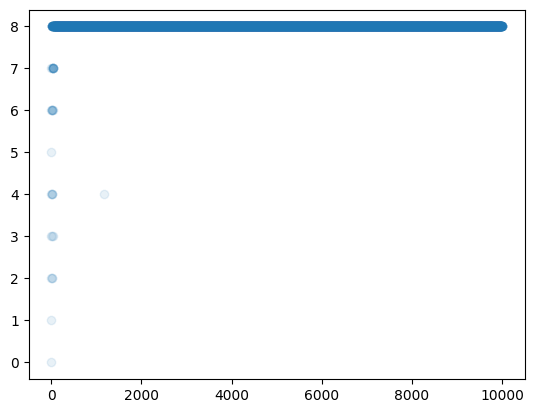

In [ ]:
# 2. feladat megoldása
agent = UCBA(len(rewards),0.05)
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

In [ ]:
# 1. feladat megoldása Thompson
class Thompson:
  def __init__(self,K):
    self.X = [] # eddigi jutalmak
    self.A = [] # melyik kart húztuk
    self.K = K  # karok száma
    self.a = np.ones(K) # Bernoulli alfa
    self.b = np.ones(K) # Bernoulli béta ha mindkettő egy, akkor nincs kezdeti feltételezésünk


  # Kötelező: melyik legyen a következő kar
  def get_arm(self):
    self.arm = np.argmax(np.random.beta(self.a, self.b))
    return self.arm

  # Kötelező: az ágens állapotának frissítése
  def update(self,reward):
    self.A += [self.arm]
    self.X += [reward]
    self.a[self.arm] += reward
    self.b[self.arm] += 1-reward

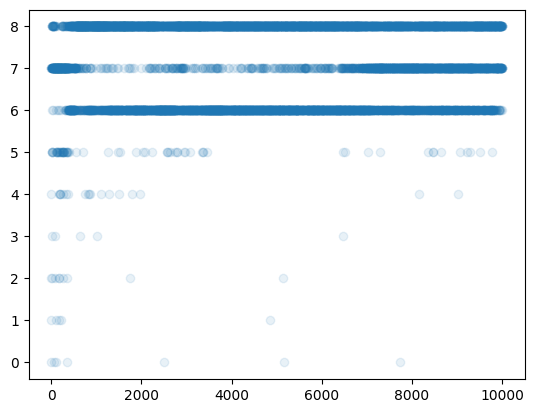

In [ ]:
# 2. feladat megoldása
agent = Thompson(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

Ügyeljen rá, hogy az eredmények az egyes futásoknál eltérhetnek, így célszerű többször is lefuttatni a méréseket. Különösen az $\varepsilon$-greedy stratégia mutat nagy variabilitást.

**2. feladat.** Végezze el a szimulációt mindegyik ágenssel, majd minden ágenshez ábrázolja scatter plot-on, mikor melyik kart húzta meg (vízszintes tengely: húzás sorszáma, függőleges tengely: meghúzott kar)! Figyelje meg az ágensek felfedező tevékenységét.


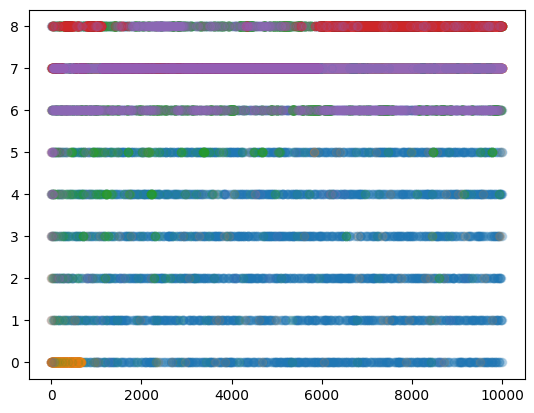

In [ ]:
# 2. feladat megoldása
agent = Agent(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

# 2. feladat megoldása Egreedy
agent = Egreedy(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

# 2. feladat megoldása UCB1
agent = UCB1(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

# 2. feladat megoldása UCBA
agent = UCBA(len(rewards),0.05)
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

# 2. feladat megoldása Thomson

agent = Thompson(len(rewards))
simulate(rewards,agent)

plt.scatter(range(len(agent.A)), agent.A,alpha=0.1)

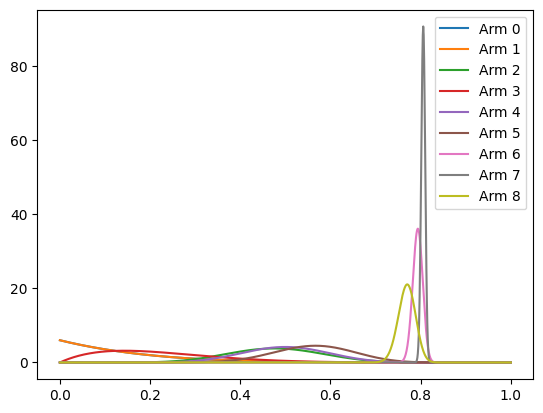

In [ ]:
x = np.linspace(0,1,1000)
for i in range(len(rewards)):
  p = beta.pdf(x,agent.a[i],agent.b[i])
  plt.plot(x,p,label=f"Arm {i}")
plt.legend()

Egy stratégia fontos jellemzője a megbánás (*regret*), ami a mi esetünkben a következőképpen definiálható:

\begin{align}
\sum_{k=1}^K n_k \left(\theta^* - \theta_k \right),
\end{align}

ahol $\theta^*$ a legjobb kar jutalmának várható értéke, $\theta_k$ pedig a $k$. karé (ami most, Bernoulli-eloszlásról lévén szó, megegyezik a paraméterrel). Azaz itt valójában azt mérjük, hogy várhatóan mennyit veszítünk amiatt, hogy a stratégiánk nem mindig a legjobb kart választja.

**3. feladat.** Értékelje ki az ágensek teljesítményét! A következőket vegye alapul:

- Átlagos jutalom
- A legjobb kar meghúzásának relatív frekvenciája
- Regret

Az eredményeket az idő (húzások) függvényében is ábrázolja! (Azaz: x tengelyen a húzás sorszáma, az y tengelyen pedik az éppen aktuális átlagjutalom/frekvencia/regret.)

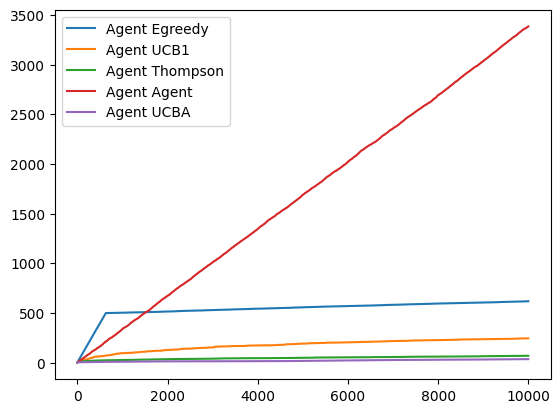

In [ ]:
# 3. feladat megoldása


agents = [Egreedy(len(rewards)), UCB1(len(rewards)), Thompson(len(rewards)), Agent(len(rewards)), UCBA(len(rewards),0.05)]
names = ['Egreedy', 'UCB1', 'Thompson', 'Agent', 'UCBA']
nm = 0
for a in agents:
  simulate(rewards, a)
  regret = np.cumsum(np.max(rewards) - np.array(rewards)[a.A])
  plt.plot(range(len(regret)),regret, label=f"Agent {names[nm]}")
  nm = nm + 1
plt.legend()

**4. feladat.** Tetszőleges problémában ábrázolja a bayesi UCB ágens $\beta$-posteriorjait a tanítás legvégén!

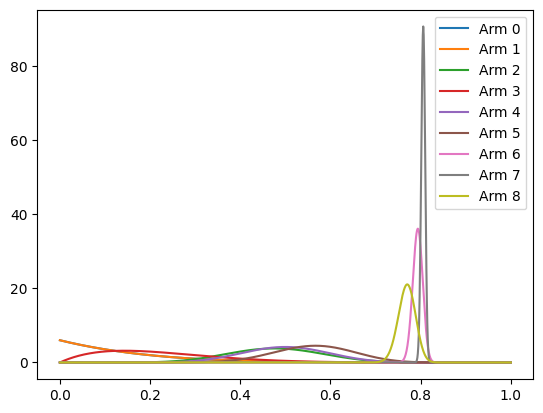

In [ ]:
# 4. feladat megoldása
x = np.linspace(0,1,1000)
for i in range(len(rewards)):
  p = beta.pdf(x,agent.a[i],agent.b[i])
  plt.plot(x,p,label=f"Arm {i}")
plt.legend()